In [1]:
msg = "Hello World"
print(msg)

Hello World


In [2]:
# configure spark variables
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

# load up other dependencies
import re
import pandas as pd

import glob

raw_data_files = glob.glob('../ansible/.results-2/bpftrace/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+-------------------------------------------------------------+
|value                                                        |
+-------------------------------------------------------------+
|Attaching 12 probes...                                       |
|Tracing latency of network stack funtions. Hit Ctrl-C to end.|
|@q1[openssl]: count 137, average 1425, total 195288          |
|@q1[ksoftirqd/169]: count 4, average 3184, total 12736       |
|                                                             |
|@q2[ksoftirqd/169]: count 25, average 858, total 21469       |
|@q2[openssl]: count 864, average 10455, total 9033468        |
|                                                             |
|                                                             |
|@q4[openssl]: count 9718, average 966, total 9388276         |
+-------------------------------------------------------------+
only showing top 10 rows



In [3]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

['Attaching 12 probes...',
 'Tracing latency of network stack funtions. Hit Ctrl-C to end.',
 '@q1[openssl]: count 137, average 1425, total 195288',
 '@q1[ksoftirqd/169]: count 4, average 3184, total 12736',
 '',
 '@q2[ksoftirqd/169]: count 25, average 858, total 21469',
 '@q2[openssl]: count 864, average 10455, total 9033468',
 '',
 '',
 '@q4[openssl]: count 9718, average 966, total 9388276',
 '@q4[ksoftirqd/169]: count 148, average 970, total 143595',
 '',
 '@q5[openssl]: count 74002, average 431, total 31956235',
 '@q5[ksoftirqd/169]: count 1057, average 436, total 461596',
 '']

In [4]:
bpftrace_ps_pattern = r'^@(q\d)\[([\d\D]*)\]\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
ps = [re.search(bpftrace_ps_pattern, item).groups()
           if re.search(bpftrace_ps_pattern, item)
           else None
           for item in sample_logs]
ps

[None,
 None,
 ('q1', 'openssl', '137', '1425', '195288', ''),
 ('q1', 'ksoftirqd/169', '4', '3184', '12736', ''),
 None,
 ('q2', 'ksoftirqd/169', '25', '858', '21469', ''),
 ('q2', 'openssl', '864', '10455', '9033468', ''),
 None,
 None,
 ('q4', 'openssl', '9718', '966', '9388276', ''),
 ('q4', 'ksoftirqd/169', '148', '970', '143595', ''),
 None,
 ('q5', 'openssl', '74002', '431', '31956235', ''),
 ('q5', 'ksoftirqd/169', '1057', '436', '461596', ''),
 None]

In [5]:
bpftrace_cs_pattern = r'^@(uc)\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
cs = [re.search(bpftrace_cs_pattern, item).groups()
           if re.search(bpftrace_cs_pattern, item)
           else None
           for item in sample_logs]
cs

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [6]:
from pyspark.sql.functions import regexp_extract

bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
).filter(' cs_count != ""')

bpftrace_cs_df.show(15)

+--------+----------+--------+
|cs_count|cs_average|cs_total|
+--------+----------+--------+
|    1991|     44252|88107530|
|    2005|      5911|11852129|
|    2242|      6424|14402877|
|    2326|      7053|16406056|
|    2034|      7738|15740927|
|    2047|      6490|13285915|
|    2184|      6485|14165366|
|    2179|      6180|13466568|
|    2014|      6787|13670960|
|    2055|      9751|20038863|
|    2339|      9044|21154001|
|    2262|      7841|17736426|
|    2327|     13797|32107008|
|    2025|      6296|12749912|
|    2178|      7067|15392406|
+--------+----------+--------+
only showing top 15 rows



In [7]:
print(bpftrace_cs_df.toPandas().to_numpy()[0])

['1991' '44252' '88107530']


In [8]:
from pyspark.sql.functions import regexp_extract

bpftrace_logs_df = base_df.select(
                                regexp_extract('value', bpftrace_ps_pattern, 1).alias('level'),
                                regexp_extract('value', bpftrace_ps_pattern, 2).alias('program'),
                                regexp_extract('value', bpftrace_ps_pattern, 3).alias('pkt_count'),
                                regexp_extract('value', bpftrace_ps_pattern, 4).alias('pkt_average'),
                                regexp_extract('value', bpftrace_ps_pattern, 5).alias('pkt_total')
                                ).filter(' level != "" ')
bpftrace_logs_df.show(15, truncate=True)

+-----+-------------+---------+-----------+---------+
|level|      program|pkt_count|pkt_average|pkt_total|
+-----+-------------+---------+-----------+---------+
|   q1|      openssl|      137|       1425|   195288|
|   q1|ksoftirqd/169|        4|       3184|    12736|
|   q2|ksoftirqd/169|       25|        858|    21469|
|   q2|      openssl|      864|      10455|  9033468|
|   q4|      openssl|     9718|        966|  9388276|
|   q4|ksoftirqd/169|      148|        970|   143595|
|   q5|      openssl|    74002|        431| 31956235|
|   q5|ksoftirqd/169|     1057|        436|   461596|
|   q1|      openssl|      290|       1230|   356844|
|   q1|ksoftirqd/169|       15|       1950|    29257|
|   q2|      openssl|     1560|        631|   985372|
|   q2|ksoftirqd/169|       53|        742|    39367|
|   q4|      openssl|    13292|        951| 12642706|
|   q4|ksoftirqd/169|      105|        979|   102854|
|   q5|      openssl|   101292|        430| 43619797|
+-----+-------------+-------

In [9]:
from pyspark.sql.functions import regexp_extract

bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
).filter(' cs_count != ""')

bpftrace_cs_df.show(15)

+--------+----------+--------+
|cs_count|cs_average|cs_total|
+--------+----------+--------+
|    1991|     44252|88107530|
|    2005|      5911|11852129|
|    2242|      6424|14402877|
|    2326|      7053|16406056|
|    2034|      7738|15740927|
|    2047|      6490|13285915|
|    2184|      6485|14165366|
|    2179|      6180|13466568|
|    2014|      6787|13670960|
|    2055|      9751|20038863|
|    2339|      9044|21154001|
|    2262|      7841|17736426|
|    2327|     13797|32107008|
|    2025|      6296|12749912|
|    2178|      7067|15392406|
+--------+----------+--------+
only showing top 15 rows



In [10]:
cs_array = bpftrace_cs_df.toPandas().to_numpy()[0]
print(cs_array)

['1991' '44252' '88107530']


In [11]:
from pyspark.sql.functions import lit

bpftrace_res_df = bpftrace_logs_df.withColumn("cs_count", lit(cs_array[0])
                    ).withColumn("cs_average", lit(cs_array[1])
                    ).withColumn("cs_total", lit(cs_array[2]))
bpftrace_res_df.show(15, truncate=True)

+-----+-------------+---------+-----------+---------+--------+----------+--------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average|cs_total|
+-----+-------------+---------+-----------+---------+--------+----------+--------+
|   q1|      openssl|      137|       1425|   195288|    1991|     44252|88107530|
|   q1|ksoftirqd/169|        4|       3184|    12736|    1991|     44252|88107530|
|   q2|ksoftirqd/169|       25|        858|    21469|    1991|     44252|88107530|
|   q2|      openssl|      864|      10455|  9033468|    1991|     44252|88107530|
|   q4|      openssl|     9718|        966|  9388276|    1991|     44252|88107530|
|   q4|ksoftirqd/169|      148|        970|   143595|    1991|     44252|88107530|
|   q5|      openssl|    74002|        431| 31956235|    1991|     44252|88107530|
|   q5|ksoftirqd/169|     1057|        436|   461596|    1991|     44252|88107530|
|   q1|      openssl|      290|       1230|   356844|    1991|     44252|88107530|
|   

In [12]:
raw_data_files = glob.glob('../ansible/.results-2/iperf/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+--------------------------------------------------------------------------------+
|value                                                                           |
+--------------------------------------------------------------------------------+
|------------------------------------------------------------                    |
|Server listening on UDP port 5001                                               |
|Receiving 1470 byte datagrams                                                   |
|UDP buffer size:  208 KByte (default)                                           |
|------------------------------------------------------------                    |
|[  3] local 10.0.0.2 port 5001 connected with 10.0.0.1 port 48362               |
|[ ID] Interval       Transfer     Bandwidth        Jitter   Lost/Total Datagrams|
|[  3]  0.0-59.9 sec  8.37 GBytes  1.20 Gbits/sec   0.013 ms 9694/6122450 (0.16%)|
+-------------------------------------------

In [13]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

iperf_s_pattern = r'[\d\D]*-([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d/]*)\D*([\d.]*)([\d\D]*)'
cs = [re.search(iperf_s_pattern, item).groups()
           if re.search(iperf_s_pattern, item)
           else None
           for item in sample_logs]
cs

[('', '', '', '', '', '', ''),
 None,
 None,
 None,
 ('', '', '', '', '', '', ''),
 None,
 None,
 ('59.9', '8.37', '1.20', '0.013', '9694/6122450', '0.16', '%)')]

In [14]:
raw_data_files = glob.glob('../ansible/.results-2/openssl/server1-1200m-1.out')
raw_data_files

base_df = spark.read.text(raw_data_files)
base_df.printSchema()

base_df.show(10, truncate=False)

root
 |-- value: string (nullable = true)

+-----------------------------------------------------------------------------+
|value                                                                        |
+-----------------------------------------------------------------------------+
|Doing aes-256 cbc for 10s on 16 size blocks: 87323033 aes-256 cbc's in 8.24s |
|Doing aes-256 cbc for 10s on 64 size blocks: 21884854 aes-256 cbc's in 7.91s |
|Doing aes-256 cbc for 10s on 256 size blocks: 5493064 aes-256 cbc's in 7.83s |
|Doing aes-256 cbc for 10s on 1024 size blocks: 1379488 aes-256 cbc's in 7.78s|
|Doing aes-256 cbc for 10s on 8192 size blocks: 172686 aes-256 cbc's in 7.81s |
|Doing aes-256 cbc for 10s on 16384 size blocks: 86258 aes-256 cbc's in 7.79s |
+-----------------------------------------------------------------------------+



In [15]:
sample_logs = [item['value'] for item in base_df.take(15)]
sample_logs

openssl_s_pattern = r'\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d.]*)([\d\D]*)'
cs = [re.search(openssl_s_pattern, item).groups()
           if re.search(openssl_s_pattern, item)
           else None
           for item in sample_logs]
cs

openssl_logs_df = base_df.select(
                                regexp_extract('value', openssl_s_pattern, 6).alias('us_time')
                                ).filter(' us_time != "" ')

openssl_logs_df.show(5)
cs_array = openssl_logs_df.toPandas().to_numpy()

us_time = 0.0
for a in cs_array:
    us_time += float(a[0])

us_time

+-------+
|us_time|
+-------+
|   8.24|
|   7.91|
|   7.83|
|   7.78|
|   7.81|
+-------+
only showing top 5 rows



47.36

In [16]:
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from functools import reduce

# schema = StructType([])
# results_df = sqlContext.createDataFrame(sc.emptyRDD(), schema)

bpftrace_ps_pattern = r'^@(q\d)\[([\d\D]*)\]\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
bpftrace_cs_pattern = r'^@(uc)\D*(\d+)\D*(\d+)\D*(\d+)([\d\D]*)'
iperf_s_pattern = r'[\d\D]*-([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d.]*)\D*([\d/]*)\D*([\d.]*)([\d\D]*)'
openssl_s_pattern = r'\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d]*)\D*([\d.]*)([\d\D]*)'


def readFiletoDF(path) -> DataFrame:
    raw_data_files = glob.glob(path)
    raw_data_files
    return spark.read.text(raw_data_files)

def readBpftracePSLogstoDF(df: DataFrame) -> DataFrame:
    bpftrace_logs_df = df.select(
                                regexp_extract('value', bpftrace_ps_pattern, 1).alias('level'),
                                regexp_extract('value', bpftrace_ps_pattern, 2).alias('program'),
                                regexp_extract('value', bpftrace_ps_pattern, 3).alias('pkt_count'),
                                regexp_extract('value', bpftrace_ps_pattern, 4).alias('pkt_average'),
                                regexp_extract('value', bpftrace_ps_pattern, 5).alias('pkt_total')
                                ).filter(' level != "" ')
    return bpftrace_logs_df

def concateBpftraceCSLogstoDF(df: DataFrame, ps_df: DataFrame) -> DataFrame:
    bpftrace_cs_df = base_df.select(
                                regexp_extract('value', bpftrace_cs_pattern, 2).alias('cs_count'),
                                regexp_extract('value', bpftrace_cs_pattern, 3).alias('cs_average'),
                                regexp_extract('value', bpftrace_cs_pattern, 4).alias('cs_total'),
                                ).filter(' cs_count != ""')

    cs_array = bpftrace_cs_df.toPandas().to_numpy()[0]

    bpftrace_res_df = ps_df.withColumn("cs_count", lit(cs_array[0])
                    ).withColumn("cs_average", lit(cs_array[1])
                    ).withColumn("cs_total", lit(cs_array[2]))
    
    return bpftrace_res_df

def concateIperfLogsToDF(df: DataFrame, in_df: DataFrame) -> DataFrame:
    iperf_logs_df = df.select(
                                regexp_extract('value', iperf_s_pattern, 1).alias('intval'),
                                regexp_extract('value', iperf_s_pattern, 2).alias('transfer'),
                                regexp_extract('value', iperf_s_pattern, 3).alias('rx_bandwidth'),
                                regexp_extract('value', iperf_s_pattern, 4).alias('jitter'),
                                regexp_extract('value', iperf_s_pattern, 6).alias('pkt_loss')
                                ).filter(' intval != "" ')
    
    cs_array = iperf_logs_df.toPandas().to_numpy()[0]

    iperf_res_df = in_df.withColumn("duration", lit(cs_array[0])
                    ).withColumn("rx_gbytes", lit(cs_array[1])
                    ).withColumn("rx_bandwidth", lit(cs_array[2])
                    ).withColumn("jitter", lit(cs_array[3])
                    ).withColumn("pkt_loss", lit(cs_array[4]))

    iperf_res_df.show(5)
    return iperf_res_df

def concateOpensslLogsToDF(df: DataFrame, in_df: DataFrame) -> DataFrame:
    openssl_logs_df = df.select(
                                regexp_extract('value', openssl_s_pattern, 6).alias('us_time')
                                ).filter(' us_time != "" ')
    
    cs_array = openssl_logs_df.toPandas().to_numpy()

    us_time = 0.0
    for a in cs_array:
        us_time += float(a[0])

    us_time

    openssl_res_df = in_df.withColumn("us_time", lit(us_time))

    return openssl_res_df

df_list = []

for x in range(1, 50):
    path = '../ansible/.results-2/bpftrace/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    ps_df = readBpftracePSLogstoDF(base_df)
    ps_cs_df = concateBpftraceCSLogstoDF(base_df, ps_df)
    df_1 = ps_cs_df.withColumn("tx_bandwidth", lit(1000 + 200*x))

    path = '../ansible/.results-2/iperf/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    df_2 = concateIperfLogsToDF(base_df, df_1)

    path = '../ansible/.results-2/openssl/server1-{}m-{}.out'.format(1000 + 200*x, x)
    base_df = readFiletoDF(path)
    # base_df.show(5, truncate=False)
    df_3 = concateOpensslLogsToDF(base_df, df_2)

    df_list.append(df_3)

results_df = reduce(lambda x, y: x.union(y), df_list)
# results_df.show(5, truncate=False)
results_df.printSchema()


+-----+-------------+---------+-----------+---------+--------+----------+--------+------------+--------+---------+------------+------+--------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average|cs_total|tx_bandwidth|duration|rx_gbytes|rx_bandwidth|jitter|pkt_loss|
+-----+-------------+---------+-----------+---------+--------+----------+--------+------------+--------+---------+------------+------+--------+
|   q1|      openssl|      137|       1425|   195288|    1991|     44252|88107530|        1200|    59.9|     8.37|        1.20| 0.013|    0.16|
|   q1|ksoftirqd/169|        4|       3184|    12736|    1991|     44252|88107530|        1200|    59.9|     8.37|        1.20| 0.013|    0.16|
|   q2|ksoftirqd/169|       25|        858|    21469|    1991|     44252|88107530|        1200|    59.9|     8.37|        1.20| 0.013|    0.16|
|   q2|      openssl|      864|      10455|  9033468|    1991|     44252|88107530|        1200|    59.9|     8.37|        1.20| 0.013|  

In [17]:
from pyspark.sql import SparkSession

results_df.show(5)
results_df.createOrReplaceTempView("LOGS")


df2=spark.sql("select level, tx_bandwidth, sum(pkt_count) as count, avg(rx_gbytes) as rx_bytes from LOGS group by level, tx_bandwidth")
df2.show(15, truncate=True)

+-----+-------------+---------+-----------+---------+--------+----------+--------+------------+--------+---------+------------+------+--------+-------+
|level|      program|pkt_count|pkt_average|pkt_total|cs_count|cs_average|cs_total|tx_bandwidth|duration|rx_gbytes|rx_bandwidth|jitter|pkt_loss|us_time|
+-----+-------------+---------+-----------+---------+--------+----------+--------+------------+--------+---------+------------+------+--------+-------+
|   q1|      openssl|      137|       1425|   195288|    1991|     44252|88107530|        1200|    59.9|     8.37|        1.20| 0.013|    0.16|  47.36|
|   q1|ksoftirqd/169|        4|       3184|    12736|    1991|     44252|88107530|        1200|    59.9|     8.37|        1.20| 0.013|    0.16|  47.36|
|   q2|ksoftirqd/169|       25|        858|    21469|    1991|     44252|88107530|        1200|    59.9|     8.37|        1.20| 0.013|    0.16|  47.36|
|   q2|      openssl|      864|      10455|  9033468|    1991|     44252|88107530|      


This graph shows the time taken executing packets on each level of packet processing for a given bandwith



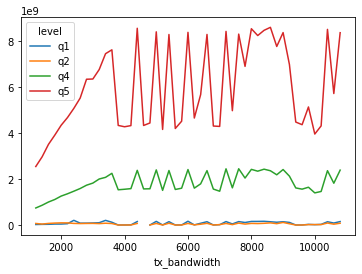

In [18]:
caption = '''
This graph shows the time taken executing packets on each level of packet processing for a given bandwith
'''

df2=spark.sql("select level, tx_bandwidth, sum(pkt_total) as time from LOGS group by level, tx_bandwidth")

df_2 = df2.toPandas()
df_2 = df_2.pivot(index='tx_bandwidth', columns='level', values='time')

df_2.plot()
print(caption)


This graph shows the amount of time spent by the CPU operating on the userspace program for each TX bandwidth



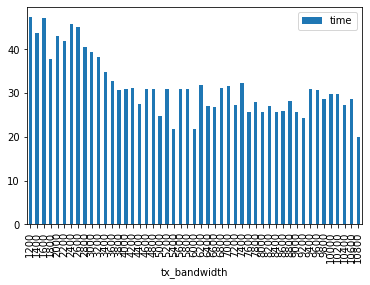

In [19]:
caption = '''
This graph shows the amount of time spent by the CPU operating on the userspace program for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(us_time) as time from LOGS group by tx_bandwidth order by tx_bandwidth")

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='time')
print(caption)



This graph shows the amount of time spent handling context switches for each TX bandwidth



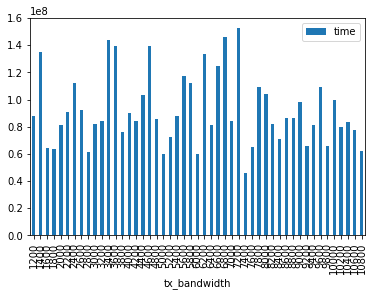

In [20]:
caption = '''
This graph shows the amount of time spent handling context switches for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(cs_total) as time from LOGS group by tx_bandwidth order by tx_bandwidth")

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='time')
print(caption)


This graph shows the number of context switches for each TX bandwidth



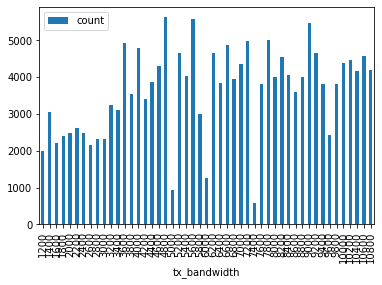

In [21]:
caption = '''
This graph shows the number of context switches for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(cs_count) as count from LOGS group by tx_bandwidth order by tx_bandwidth")

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='count')
print(caption)

+-----+------------+------------------+
|level|tx_bandwidth|         rx_gbytes|
+-----+------------+------------------+
|   q2|        1200| 8.369999999999989|
|   q5|        1200| 8.369999999999989|
|   q1|        1200| 8.370000000000003|
|   q4|        1200| 8.369999999999989|
|   q5|        1400| 9.759999999999993|
|   q4|        1400| 9.759999999999993|
|   q1|        1400| 9.759999999999993|
|   q2|        1400| 9.759999999999993|
|   q5|        1600|11.200000000000028|
|   q4|        1600|11.200000000000028|
|   q1|        1600|11.200000000000026|
|   q2|        1600|11.200000000000028|
|   q4|        1800|              12.5|
|   q1|        1800|              12.5|
|   q5|        1800|              12.5|
+-----+------------+------------------+
only showing top 15 rows



<AxesSubplot:xlabel='tx_bandwidth'>

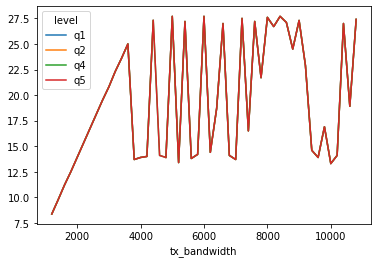

In [22]:
caption = '''
This graph shows the amount of giga bytes on each level of packet processing for a given bandwith
'''

results_df.createOrReplaceTempView("LOGS")
df2=spark.sql("select level, tx_bandwidth, avg(rx_gbytes) as rx_gbytes from LOGS group by level, tx_bandwidth order by tx_bandwidth ")
df2.show(15, truncate=True)

df_2 = df2.toPandas()
df_2 = df_2.pivot(index='tx_bandwidth', columns='level', values='rx_gbytes')

df_2.plot()

+------------+------------------+
|tx_bandwidth|         rx_gbytes|
+------------+------------------+
|        3000|20.799999999999862|
|        4000|13.900000000000029|
|        2200|15.300000000000047|
|        7800| 21.69999999999987|
|        4200|              14.0|
|       10800|27.399999999999746|
|        7600|27.200000000000262|
|       10600|18.899999999999913|
|        3200|  22.2999999999998|
|        7400|              16.5|
|        8200|26.700000000000216|
|        1400| 9.760000000000135|
|        2600|18.100000000000193|
|        5000|27.700000000000262|
|        8800|              24.5|
+------------+------------------+
only showing top 15 rows


This graph shows the number of context switches for each TX bandwidth



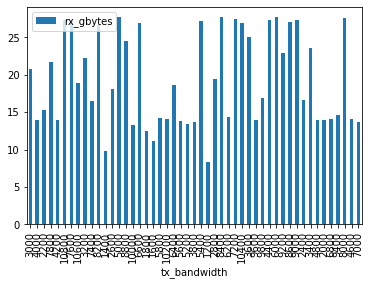

In [23]:
caption = '''
This graph shows the number of context switches for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(rx_gbytes) rx_gbytes from LOGS group by tx_bandwidth")
df3.show(15, truncate=True)

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='rx_gbytes')
print(caption)

+------------+-------------------+
|tx_bandwidth|           pkt_loss|
+------------+-------------------+
|        3000|                0.5|
|        4000|               50.0|
|        2200|0.11999999999999944|
|        7800|               26.0|
|        4200|               49.0|
|       10800| 0.5500000000000059|
|        7600| 0.6100000000000083|
|       10600|               34.0|
|        3200|0.34999999999999637|
|        7400|               42.0|
|        8200|  9.199999999999912|
|        1400|0.15999999999999784|
|        2600| 0.4700000000000005|
|        5000| 0.5899999999999972|
|        8800|               10.0|
+------------+-------------------+
only showing top 15 rows


This graph shows the packet loss for each TX bandwidth



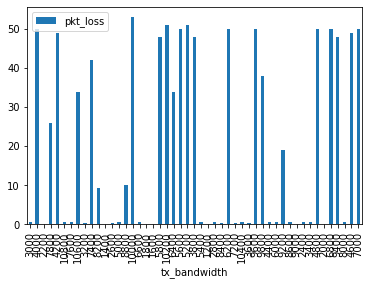

In [24]:
caption = '''
This graph shows the packet loss for each TX bandwidth
'''
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

results_df.createOrReplaceTempView("LOGS")
df3=spark.sql("select tx_bandwidth, avg(pkt_loss) pkt_loss from LOGS group by tx_bandwidth")
df3.show(15, truncate=True)

df_3 = df3.toPandas()

df_3.plot(kind='bar', x='tx_bandwidth', y='pkt_loss')
print(caption)